**This notebook is to be used in conjunction with the other resources in this repository.*

Much investigation is carried out to predict the annual energy production (AEP), and Cost of Energy (COE) of wind farms in assessment of the viability of wind energy projects. Wind farm layout design is a multidisciplinary process with many design variables. Aerodynamic variables including wind speed and direction are  characterized by much uncertainty. However in some simulations these are usually treated deterministically, resulting in energy underproduction in the operational lifetimes of farms. To develop more robust models the afore mentioned design variables must be properly described to present a near real life situation. This work focuses on the quantification of uncertainties associated with yaw orientation, and wind speeds in wind farm layout optimization with Monte Carlo Methods. An understanding, and proper treatment of these uncertainties will greatly aid in the realization of more robust farm layout designs, ultimately improving the accuracy of annual power output predictions.


### Example 1: AEP  Calculation

The amount of wind energy converted into electrical energy by a wind farm is primarily dependent on the wind speed which is greatly reduced in wake regions. These are regions downstream of turbines where the wind speed is less than the free stream. They occur as a result of ... Kinematic models obtained from soloving the momentum equations are used to charaterize estimate the hub velocity of downstream turbines. One of the oldest of such models, created by N.O. Jensen is used in this work to estimate the wake effects and calculate the effective hub velocities due to it's simplicity. It is a simple wake model, assuming a linearly expanding wake with a
velocity deficit that is only dependent of the distance behind the rotor. The wake diameter $D_w$ is given by

\begin{equation}
D_w = D(1 + 2ks)
\end{equation}

where $k$ is the wake decay constant with a typical value of 0.075 for land cases, and $s$ the relative distance behind the rotor defined as $s = x/D$. The velocity in the wake is then given by

\begin{equation}
u = U_{\infty}\Bigg[1 - \frac{1-\sqrt{1-C_T}}{(1+2ks)^2}\Bigg]
\end{equation}

$C_T$ is the thrust coefficient of the rotor which is ususally smaller than 1. The reader is refered to [] for a detailed description of the Jensen wake model.

We proceed by considering the power of a wind farm to be a function of three classes of variables: uncertain variables $\zeta$, design variables $x$, and parameters $\theta$, $ P = P(\zeta, x, \theta)$.

  
|   |   |
|:---:|:---:|
| **Design, $x,y$:** | turbine locations x, and y |
| **Uncertain variables, $\boldsymbol{\zeta}$:** | wind, speed and direction |
| **Parameters, $\theta$:** | yaw angles, turbine characteristics, and wake model parameters|



Uncertain variables are variables that follow a probability distribution, design variables are variables that an optimizer can vary, and parameters are constants. The classification of the variables is problem dependent. For instance, the height of a turbine could be considered as a design variable if we allow the optimizer to vary it, as an uncertain variable if we assume that due to terrain or manufacturing variability the exact height is unknown but follows a particular probability distribution, or as a parameter if we set the turbine height in the model at a fixed value. Another example is the rotor yaw, which can be considered a design variable or a parameter. A tunable parameter of a wake model, such as the wake coefficient expansion, could be
considered as a parameter or as an uncertain variable given by a particular distribution.
Table 1 lists the category of each variable that influences the power computation in this work. 

The power of the wind farm for a given wind direction and wind speed is equal to the sum of the power produced by each turbine

\begin{equation}
 P = \sum_{i=1}^{n_{turb}} P_{i} 
\end{equation}

The power of each turbine is calculated from

\begin{equation}
 P_{i} = \frac{1}{2}\rho C_P A U_{i}^{3} 
\end{equation}

where $\rho$ is the air density, $A$ is the rotor swept area, $C_P$ is the power coefficient, and $U_i$ is the effective hub velocity for each turbine, which is calculated by the wake model and is a function of the three types of variables described above.



In [345]:
import numpy as np

"""the Jensen wake model"""

def Jensen_wake(x,y, U):
    
    k = 0.075      # wake decay constant
    D = 126.4      # rotor diameter
    Ct = 0.8       # thrust coefficient
    
    s = x/D        # relative distance downwind 
    
    Dw = D* (1. + 2.*k*s)               # wake diameter
       
    U_hub = U*(1. - (1. - np.sqrt(1. - Ct))/(1. + s*k*s)**2)          # hub velocity
    
    return U_hub

#### Farm Layout

We begin by calculating the total power of a simplified wind farm with only four turbines arranged in a 2 x 2 gird with a spacing of 3 turbine diameters. The prevailing wind direction is due west as indicated by the red arrows in the figure below. 


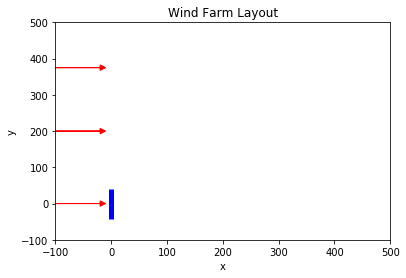

In [408]:
"""layout visualization"""

import matplotlib.pyplot as plt

D = 126.4          # rotor diameter

x = [0., 3.*D, 3.*D, 0.]            # x and y locations
y = [0., 0., 3.*D, 3.*D]

plt.figure()
ax = plt.axes()
ax.arrow(-120, 375, 100., 0., head_width=15, head_length=10, fc='r', ec='r')
ax.arrow(-120, 200, 100., 0., head_width=15, head_length=10, fc='r', ec='r')
ax.arrow(-120, 0, 100., 0., head_width=15, head_length=10, fc='r', ec='r')

plt.plot(x, y, "b|", markersize=30, mew=5)
plt.xlim(-100, 500)
plt.ylim(-100, 500)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Wind Farm Layout")
plt.show()

In [410]:
""" Power calculation """


def Jensen_Power(x, y, U):
    
    rho = 1.1716                   # air density   
    a = 1. / 3.                    # axial induction
    Cp = 4.*a*(1-a)**2.            #power coefficient
    
    D = 126.4
    
    r0 = D/2.

    A = np.pi*r0**2        #  rotor swept area
    
    U_hub1 = np.zeros(len(x))
    Power = np.zeros(len(x))
    
    
    U_hub1[0] = U
    U_hub1[1] = Jensen_wake((x[1]-x[0]), (y[1]-y[0]), U)
    U_hub1[2] = Jensen_wake((x[2]-x[3]), (y[2]-y[3]), U)
    U_hub1[3] = U
    
    # Calculate power from each turbine
    for i in range(len(U_hub1)):
        
        Power[i] = 0.5*rho*Cp*A*U_hub1[i]**3
           
    return Power

U = 8.

print "Power:", Jensen_Power(x,y, U), "W"


Power: [ 2230280.95623081  2218725.30291827  2218725.30291827  2230280.95623081] W


The power from each from each of the four turbines is printed above. Due to the symmetry (and simplicity) of this problem we see that power from the two leftmost turbines is identical as is that from the two downwind (rightmost) ones. The lower power is an indication of wake effects previously mentioned.

We however need more information to meaningfully calculate the AEP since it is a function of the expected power.
Mathematically given as,

\begin{equation}
AEP = 8760\frac{hr}{yr} E[P(\boldsymbol{\zeta})]\\
where \quad \quad E[P(\boldsymbol{\zeta})] =  \int _{\Omega} P(\boldsymbol{\zeta}) \rho(\boldsymbol{\zeta}) d\boldsymbol{\zeta}
\end{equation}

where $\boldsymbol{\zeta} = (\zeta_1 , \zeta_2 , . . . , \zeta_n)$ is a vector of random variables (the uncertain variables), $\rho(\boldsymbol{\zeta}) = \prod_{k=1}^{n} \rho_k (\zeta_k)$ is the joint probability density function of the uncertain variables, which we assume to be independent, $\Omega$ is the domain of the uncertain variables, and $P$ is the power produced in the wind farm. Common uncertain variables are the wind direction and the freestream wind speed. 

We now compute the AEP deterministically, by considering the wind speed to be constant value of $8 m/s$ all year round.



In [411]:
# deterministic AEP calculation

Powers = Jensen_Power(x, y, U)
# print Powers
Average_Power = np.mean(Powers)

AEP = 8760 * Average_Power/1000000000. 
              
print AEP, "GWh"

19.4866474151 GWh


In reality however the wind speed is characterized by variability, and is typically modelled with a Weibull distribution. In this problem we use Weibull distribution that gives a minimum speed of $0 m/s$ and a maximum of $40 m/s$ with an average speed of $8 m/s$.

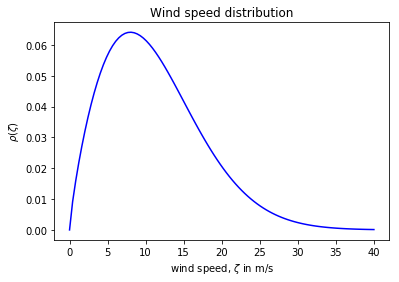

In [366]:
# Weibul distribution

def Weibull(a, b, x1):
    a = 1.8
    b = 12.552983
    lo = 0.0
    hi = 40.0  # cdf(80) = 1, to machine precision
    
    F = 1 - np.exp(-(x1/b)**a)   # cdf
    
    f = a/b * (x1/b)**(a-1) * np.exp(-(x1/b)**a)  # pdf
    
#     bnd = [lo, hi]

    return f#, F


x1 = np.linspace(0,40,100)
plt.figure()
plt.plot(x1, Weibull(1.8,12.55, x1),'b-')
plt.xlabel('wind speed, $\zeta$ in m/s')
plt.ylabel('$\\rho(\zeta)$')
plt.title('Wind speed distribution')
plt.show()

# f = Weibull(1.8,12.55,0.0, 40.0, x1)
# print f.sample(20)

We will first do a quick Monte Carlo simulation for an accurate baseline AEP to compare our results with. We can see from the convergence plot below that a $100000$ samples (using Hammersly sampling) will be sufficient for this analysis.

In [403]:
import chaospy  as cp

dist = cp.Weibull(1.8, 12.55, 0.) # wind speed distribution

U_inf = dist.sample(120000, "M")

solves = np.zeros((len(U_inf), len(x)))
mu_mc = np.zeros(len(U_inf))

for i in range(len(solves)):
    solves[i,:] = Jensen_Power(x,y, U_inf[i])# for s in U_inf]
    mu_mc[i] = np.mean(solves[i,:])

# print solves

AEP_mc = 8760*np.mean(mu_mc)/1000000000., "GWh"

print AEP_mc

(86.102098875051453, 'GWh')


Next we calculate the AEP with polynomial chaos expansions. The power will be approximated with a polynomial as

\begin{equation}
P(\zeta) \approx \sum_{i=0}^{n}\alpha_i \phi_i (\zeta)
\end{equation}

where $\alpha_i$ are the expansion coefficients, and $\phi_i$ orthogonal polynomials with respect to the pdf of the uncertain variable; the wind speed in this case. The mean power $E[P(\zeta)] = \alpha_0$, the first expansion coefficient. The $AEP$ will then be calculated as

\begin{equation}
AEP = E[P(\zeta)] \times hours/year
\end{equation}

We will calculate the expansion coefficients using both methods discussed in [] --- quadrature, and regression.

In [404]:
# Quadrature

order = 5

poly = cp.orth_ttr(order, dist)
nodes, weights = cp.generate_quadrature(order+1, dist1, rule="G")

solves1 = [Jensen_Power(x, y, s) for s in nodes.T]
P_hat1 = cp.fit_quadrature(poly, nodes, weights,solves1)

mu_quad = cp.E(P_hat1, dist)     # mean from the quadrature method

AEP_quad = 8760*np.mean(mu_quad)/1000000000.,

print AEP_quad,":,GWh"

# Regression

nodes2 = dist1.sample(3*len(poly), "H")

solves2 = [Jensen_Power(x,y, s) for s in nodes2.T]
P_hat2 = cp.fit_regression(poly, nodes2, solves2,rule="T")

mu_reg = cp.E(P_hat2, dist)     #mean from regression

AEP_reg = 8760*np.mean(mean2)/1000000000., 

print AEP_reg,":,GWh"

(86.119744636379266,) :,GWh
(86.119744373681428,) :,GWh


The AEP's calculated using both methods are identical since it is a function of the mean power (the first expansion coefficient) which calculated from the same expansion is the same.

### Discussion

The table below gives a summary of the results obtained from the different methods. We can see a strong agreement between Monte Carlo and polynomial chaos. The deterministic case is however significantly lower. This is largely due to the farm layout used in this analysis. A larger wind farm with turbines more spread out will show results from all methods in better agreement. A more meaningful study will aslo include an optimization of say positioning for AEP, or COE.

|**Method**| **AEP (GWh) **|
|:---:|:---:|
|Deterministic| 14.826 |
|Monte Carlo| 86.099 |
|PC_regression| 86.120 |
|PC_quadrature|  86.120|




### References
